# Classifying handwritten digits using k-means

Although the last application was a pretty creative use of $k$-means, we can do better still.
We have previously discussed k-means in the context of unsupervised learning, where we
tried to discover some hidden structure in the data.

However, doesn't the same concept apply to most classification tasks? Let's say our task was
to classify handwritten digits. Don't most zeros look similar, if not the same? And don't all
zeros look categorically different from all possible ones? Isn't this exactly the kind of
"hidden structure" we set out to discover with unsupervised learning? Doesn't this mean we
could use clustering for classification as well?

Let's find out together. In this section, we will attempt to use k-means to try and classify
handwritten digits. In other words, we will try to identify similar digits without using the
original label information.

## Loading the dataset

From the earlier chapters, you might recall that scikit-learn provides a whole range of
handwritten digits via its `load_digits` utility function. The dataset consists of 1,797
samples with 64 features each, where each of the features has the brightness of one pixel in
an 8 x 8 image:

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

## Running k-means

Setting up $k$-means works exactly the same as in the previous examples. We tell the
algorithm to perform at most 10 iterations and stop the process if our prediction of the
cluster centers does not improve within a distance of 1.0:

In [2]:
import cv2
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

Then we apply $k$-means to the data as we did before. Since there are 10 different digits (0-9),
we tell the algorithm to look for 10 distinct clusters:

In [3]:
import numpy as np
compactness, clusters, centers = cv2.kmeans(digits.data.astype(np.float32), 10, None, criteria, 10, flags)

And done!

Similar to the $N \times 3$ matrix that represented different RGB colors, this time, the centers array
consists of $N \times 8 \times 8$ center images, where $N$ is the number of clusters. Therefore, if we want
to plot the centers, we have to reshape the `centers` matrix back into 8 x 8 images:

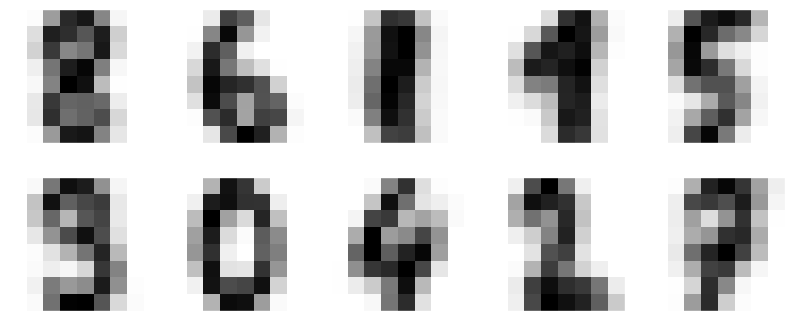

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
centers = centers.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.savefig('digits.png')

Look familiar?

Remarkably, $k$-means was able to partition the digit images not just into any 10 random
clusters, but into the digits 0-9! In order to find out which images were grouped into which
clusters, we need to generate a labels vector as we know it from supervised learning
problems:

In [5]:
from scipy.stats import mode

labels = np.zeros_like(clusters.ravel())
for i in range(10):
    mask = (clusters.ravel() == i)
    labels[mask] = mode(digits.target[mask])[0]

Then we can calculate the performance of the algorithm using scikit-learn's
accuracy_score metric:

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7846410684474123

Remarkably, $k$-means achieved 78.4% accuracy without knowing the first thing about the
labels of the original images!

We can gain more insights about what went wrong and how by looking at the **confusion
matrix**. The confusion matrix is a 2D matrix $C$, where every element $C_{i,j}$ is equal to the
number of observations known to be in group (or cluster) $i$, but predicted to be in group $j$.
Thus, all elements on the diagonal of the matrix represent data points that have been
correctly classified (that is, known to be in group $i$ and predicted to be in group $i$). Off-diagonal
elements show misclassifications.

In scikit-learn, creating a confusion matrix is essentially a one-liner:

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(digits.target, labels)

array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0, 154,  25,   0,   0,   1,   2,   0,   0,   0],
       [  1,   3, 147,  11,   0,   0,   0,   3,  12,   0],
       [  0,   1,   2, 159,   0,   2,   0,   9,  10,   0],
       [  0,  12,   0,   0, 162,   0,   0,   5,   2,   0],
       [  0,   0,   0,  40,   2, 138,   2,   0,   0,   0],
       [  1,   2,   0,   0,   0,   0, 177,   0,   1,   0],
       [  0,  14,   0,   0,   0,   0,   0, 164,   1,   0],
       [  0,  23,   3,   8,   0,   5,   1,   2, 132,   0],
       [  0,  21,   0, 145,   0,   5,   0,   8,   1,   0]])

The confusion matrix tells us that $k$-means did a pretty good job at classifying data points
from the first nine classes; however, it confused all nines to be (mostly) threes. Still, this
result is pretty solid, given that the algorithm had no target labels to be trained on.